In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from IPython.display import Markdown, display
from matplotlib.lines import Line2D

import time
import tqdm
import warnings
from scipy import integrate

from scipy import stats
random_state = 999
from copy import deepcopy



## General importsÇ
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from matplotlib.colors import ListedColormap

%matplotlib inline

## SKLearn imports
from sklearn import linear_model, svm
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA


## AIF360 imports
from aif360.datasets import BinaryLabelDataset, StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc import OptimPreproc
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
            import load_preproc_data_adult, load_preproc_data_german, load_preproc_data_compas
from aif360.algorithms.preprocessing.optim_preproc_helpers.distortion_functions\
            import get_distortion_adult, get_distortion_german, get_distortion_compas

from aif360.algorithms.preprocessing.optim_preproc_helpers.opt_tools import OptTools


#SEC_ML imports
from secml.data.c_dataset import CDataset
from secml.ml.classifiers import CClassifierSVM, CClassifierLogistic
from secml.ml.kernels import CKernelRBF, CKernelLinear
from secml.ml.peval.metrics import CMetricAccuracy
from secml.data.splitter import CDataSplitterKFold

# Poisoning attacks
from secml.adv.attacks import CAttackPoisoningSVM
from secml.adv.attacks.poisoning.c_attack_poisoning_logistic_regression import CAttackPoisoningLogisticRegression

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

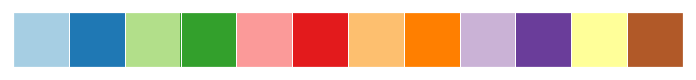

In [2]:
custom_palette=sns.diverging_palette(255, 133, l=60, n=12, center="dark")
sns.palplot(sns.color_palette("Paired", 12))
sns.set_palette(sns.color_palette("Paired"))
sns.set_style("white")
sns.set_context("paper", rc={"font.size":16,"axes.titlesize":20,"axes.labelsize":16})

## 1. Data Generator

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 999
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

def get_data(dataset_used = "compas"):
    # import dataset
    #sdataset_used = "compas" # "adult", "german", "compas"
    protected_attribute_used = 1 # 1, 2

    if dataset_used == "adult":
        if protected_attribute_used == 1:
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_adult(['sex'])
        else:
            privileged_groups = [{'race': 1}]
            unprivileged_groups = [{'race': 0}]
            dataset_orig = load_preproc_data_adult(['race'])

        optim_options = {
            "distortion_fun": get_distortion_adult,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }

    elif dataset_used == "german":
        if protected_attribute_used == 1:
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_german(['sex'])
            optim_options = {
                "distortion_fun": get_distortion_german,
                "epsilon": 0.05,
                "clist": [0.99, 1.99, 2.99],
                "dlist": [.1, 0.05, 0]
            }
            ## Changing labels to 0-1
            dataset_orig.labels[dataset_orig.labels==2]=0
            dataset_orig.unfavorable_label=0.0

        else:
            privileged_groups = [{'age': 1}]
            unprivileged_groups = [{'age': 0}]
            dataset_orig = load_preproc_data_german(['age'])
            optim_options = {
                "distortion_fun": get_distortion_german,
                "epsilon": 0.1,
                "clist": [0.99, 1.99, 2.99],
                "dlist": [.1, 0.05, 0]
            }    

    elif dataset_used == "compas":
        if protected_attribute_used == 1:     
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_compas(['sex'])
        else:
            privileged_groups = [{'race': 1}]
            unprivileged_groups = [{'race': 0}]
            dataset_orig = load_preproc_data_compas(['race'])

        optim_options = {
            "distortion_fun": get_distortion_compas,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }


    #random seed
    np.random.seed(1)

    dataset_aif360 = dataset_orig
    
    # Split into train, validation, and test
    dataset_orig_train, dataset_orig_vt = dataset_aif360.split([0.2], shuffle=True)
    dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)
    
    dataset_aif360 = dataset_orig_train.copy()
    
    SENSIBLE_ATT_INDEX = dataset_orig.feature_names.index(dataset_orig.protected_attribute_names[0])

    ## Correcting labels assignation
    if dataset_aif360.unfavorable_label != 0:
        Y = dataset_aif360.labels
        Y[Y == dataset_aif360.unfavorable_label] = -1
        Y[Y == dataset_aif360.favorable_label] = 1
        Y[Y == -1] = 0

        dataset_aif360.unfavorable_label = 0
        dataset_aif360.favorable_label = 1
    #np.delete(dataset_aif360.features, SENSIBLE_ATT_INDEX, axis=1)    
    sec_ml_dataset = CDataset(dataset_aif360.features , dataset_aif360.labels)
    
    return sec_ml_dataset.X.get_data(), sec_ml_dataset.Y.get_data(), SENSIBLE_ATT_INDEX
    
import math
import numpy as np
import matplotlib.pyplot as plt # for plotting stuff
from random import seed, shuffle
from scipy.stats import multivariate_normal # generating synthetic data
SEED = 1122334455
seed(SEED) # set the random seed so that the random permutations can be reproduced again
np.random.seed(SEED)

def get_data2(dataset_used = "compas"):
    # import dataset
    #sdataset_used = "compas" # "adult", "german", "compas"
    protected_attribute_used = 1 # 1, 2

    if dataset_used == dataset_used:
        if protected_attribute_used == 1:
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_adult(['sex'])
        else:
            privileged_groups = [{'race': 1}]
            unprivileged_groups = [{'race': 0}]
            dataset_orig = load_preproc_data_adult(['race'])

        optim_options = {
            "distortion_fun": get_distortion_adult,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }

    elif dataset_used == "german":
        if protected_attribute_used == 1:
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_german(['sex'])
            optim_options = {
                "distortion_fun": get_distortion_german,
                "epsilon": 0.05,
                "clist": [0.99, 1.99, 2.99],
                "dlist": [.1, 0.05, 0]
            }
            ## Changing labels to 0-1
            dataset_orig.labels[dataset_orig.labels==2]=0
            dataset_orig.unfavorable_label=0.0

        else:
            privileged_groups = [{'age': 1}]
            unprivileged_groups = [{'age': 0}]
            dataset_orig = load_preproc_data_german(['age'])
            optim_options = {
                "distortion_fun": get_distortion_german,
                "epsilon": 0.1,
                "clist": [0.99, 1.99, 2.99],
                "dlist": [.1, 0.05, 0]
            }    

    elif dataset_used == "compas":
        if protected_attribute_used == 1:     
            privileged_groups = [{'sex': 1}]
            unprivileged_groups = [{'sex': 0}]
            dataset_orig = load_preproc_data_compas(['sex'])
        else:
            privileged_groups = [{'race': 1}]
            unprivileged_groups = [{'race': 0}]
            dataset_orig = load_preproc_data_compas(['race'])

        optim_options = {
            "distortion_fun": get_distortion_compas,
            "epsilon": 0.05,
            "clist": [0.99, 1.99, 2.99],
            "dlist": [.1, 0.05, 0]
        }


    #random seed
    np.random.seed(1)

    dataset_aif360 = dataset_orig
    
    # Split into train, validation, and test
    dataset_orig_train, dataset_orig_vt = dataset_aif360.split([0.8], shuffle=True)
    dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)
    
    dataset_aif360 = dataset_orig_vt.copy()
    
    SENSIBLE_ATT_INDEX = dataset_orig.feature_names.index(dataset_orig.protected_attribute_names[0])

    ## Correcting labels assignation
    if dataset_aif360.unfavorable_label != 0:
        Y = dataset_aif360.labels
        Y[Y == dataset_aif360.unfavorable_label] = 1
        Y[Y == dataset_aif360.favorable_label] = -1
       
        # original 
        # Y[Y == dataset_aif360.unfavorable_label] = -1   
        # Y[Y == dataset_aif360.favorable_label] = 1
        Y[Y == -1] = 0

        dataset_aif360.unfavorable_label = 0
        dataset_aif360.favorable_label = 1
    #np.delete(dataset_aif360.features, SENSIBLE_ATT_INDEX, axis=1)    
    sec_ml_dataset = CDataset(dataset_aif360.features , dataset_aif360.labels)
    
    return sec_ml_dataset.X.get_data(), sec_ml_dataset.Y.get_data(), SENSIBLE_ATT_INDEX
    

## 2. Creating custom Weighted CLoss to solve the optimization

In [4]:

from secml.ml.classifiers.loss import CLossClassification, CLossLogistic
from secml.array import CArray

In [5]:
class CLossDisparateImpact(CLossClassification):
    """Surrogate function of disparate impact.

    Attributes
    ----------
    class_type : 'log'
    suitable_for : 'classification'

    """
    __class_type = 'dimp_log'

    def __init__(self, _privileged_condition):
        self._privileged_condition = CArray(_privileged_condition)

    def unprivileged(self):
        """Give 1 to unprivileged, 0 to privileged"""
        y = CArray.zeros(self._privileged_condition.size)
        y[self._privileged_condition == 0] = 1
        return y

    def loss(self, y_true, score, pos_label=1):
        """Computes loss_priv-loss_unpriv, which is what we aim to max"""
        # give 1 to unpriv, 0 to priv
        y = self.unprivileged()
        p_priv = (y == 0).sum() / y.size
        p_unpriv = (y == 1).sum() / y.size
        # loss = (score >= 0) != y  # zero-one loss
        loss = CLossLogistic().loss(y_true=y, score=score)  # smoothed version
        loss[y == 1] *= -p_priv / p_unpriv  # rebalance class weights
        return -abs(loss)

    def dloss(self, y_true, score, pos_label=1):
        """Computes the derivative of the loss vs score."""
        y = self.unprivileged()
        p_priv = (y == 0).sum() / y.size
        p_unpriv = (y == 1).sum() / y.size
        grad = CLossLogistic().dloss(y, score, pos_label)
        grad[y == 1] *= -p_priv / p_unpriv  # rebalance class weights
        return grad

## 3. Helper functions

In [6]:
def calculate_disparate_impact(y,sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=False):
    
    privileged = y[sensible_att_vals == privileged_classes]
    unprivileged = y[sensible_att_vals != privileged_classes]
    
    unprivileged_favorable = unprivileged[unprivileged==favorable_output]
    privileged_favorable = privileged[privileged==favorable_output]
    
    n1 =  (len(unprivileged_favorable)/ len(unprivileged))
    n2 = (len(privileged_favorable)/ len(privileged))
    
    if verbose:
        print("\tUnprivileged favorable1: ", n1)
        print("\tPrivileged favorable2: ", n2)
     
    disparate_impact = n1 - n2 #(max(n2,0.1)) 
    return disparate_impact

def calculate_error_rate_ratio(y_true, y_pred,sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=True):
    privileged_y_true = y_true[sensible_att_vals == privileged_classes]
    unprivileged_y_true = y_true[sensible_att_vals != privileged_classes]
    
    privileged_y_pred = y_pred[sensible_att_vals == privileged_classes]
    unprivileged_y_pred = y_pred[sensible_att_vals != privileged_classes]
    
    privileged_num_errors = len(privileged_y_true) - (len(np.where(np.isclose(privileged_y_true, privileged_y_pred))[0]))
    unprivileged_num_errors = len(unprivileged_y_true) - (len(np.where(np.isclose(unprivileged_y_true, unprivileged_y_pred))[0]))
    
    if verbose:
        print("\tN1: ", n1)
        print("\tN2: ", n2)
        
    
        
    error_rate = (unprivileged_num_errors / len(unprivileged_y_true)) / (privileged_num_errors / len(privileged_y_true))
    return error_rate

#12[(𝐹𝑃𝑅𝐷=unprivileged−𝐹𝑃𝑅𝐷=privileged)+(𝑇𝑃𝑅𝐷=unprivileged−𝑇𝑃𝑅𝐷=privileged))]
def get_average_odds_difference(y_true, y_pred, sensible_att_vals, privileged_classes=1, favorable_output=1):
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)    

    sensible_att_vals = np.array(sensible_att_vals)
                                 
    privileged_y_true = y_true[sensible_att_vals == privileged_classes]
    unprivileged_y_true = y_true[sensible_att_vals != privileged_classes]
    
    privileged_y_pred = y_pred[sensible_att_vals == privileged_classes]
    unprivileged_y_pred = y_pred[sensible_att_vals != privileged_classes]
                                 
                                 
    FPR_unprivileged = get_false_positive_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    FPR_privileged = get_false_positive_rate(privileged_y_true, privileged_y_pred, favorable_output)
    TPR_unprivileged = get_true_positive_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    TPR_privileged = get_true_positive_rate(privileged_y_true, privileged_y_pred, favorable_output)
                              
    return 0.5 * abs((FPR_unprivileged - FPR_privileged) + (TPR_unprivileged - TPR_privileged))
    
    

def get_false_positive_rate(y_true, y_pred, favorable_output):
    _tmp1 = y_pred[y_true!=favorable_output]
    fp = _tmp1[_tmp1 == favorable_output]
    
    N = len(y_true[y_true != favorable_output])
    
    if N == 0:
        return 0
    
    return len(fp) / N

def get_true_positive_rate(y_true, y_pred, favorable_output):
    _tmp1 = y_pred[y_true==favorable_output]
    fp = _tmp1[_tmp1 == favorable_output]
    
    P = len(y_true[y_true == favorable_output])
    
    if N == 0:
        return 0
    
    return len(fp) / P
    
    
def get_false_negative_rate(y_true, y_pred, favorable_output):
    _tmp = y_pred[y_true==favorable_output]
    
    fn = _tmp[_tmp != favorable_output]
    
    P = len(y_true[y_true != favorable_output])
    
    if P == 0:
        return 0
    
    return len(fn) / P

def get_error_rates(y_true, y_pred, sensible_att_vals, privileged_classes=1, favorable_output=1, verbose=False):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)    

    sensible_att_vals = np.array(sensible_att_vals)
    
    
    
    privileged_y_true = y_true[sensible_att_vals == privileged_classes]
    unprivileged_y_true = y_true[sensible_att_vals != privileged_classes]
    
    privileged_y_pred = y_pred[sensible_att_vals == privileged_classes]
    unprivileged_y_pred = y_pred[sensible_att_vals != privileged_classes]
    """
    privileged_num_errors = len(privileged_y_true) - (len(np.where(np.isclose(privileged_y_true, privileged_y_pred))[0]))
    unprivileged_num_errors = len(unprivileged_y_true) - (len(np.where(np.isclose(unprivileged_y_true, unprivileged_y_pred))[0]))
    
    if verbose:
        print("\tN1: ", n1)
        print("\tN2: ", n2)

        error_rate = (unprivileged_num_errors / len(unprivileged_y_true)) / (privileged_num_errors / len(privileged_y_true))
    """
    
    FNR_privileged = get_false_negative_rate(privileged_y_true, privileged_y_pred, favorable_output)
    FNR_unprivileged = get_false_negative_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    
    FPR_privileged = get_false_positive_rate(privileged_y_true, privileged_y_pred, favorable_output)
    FPR_unprivileged = get_false_positive_rate(unprivileged_y_true, unprivileged_y_pred, favorable_output)
    
    
    if verbose:
        print("\tFNR_1: ", FNR_privileged)
        print("\tFNR_2: ", FNR_unprivileged)
        print("\tFPR_1: ", FPR_privileged)
        print("\tFPR_2: ", FPR_unprivileged)
    
    FNR = -1
    FPR = -1
    
    try:
        FNR = FNR_unprivileged / FNR_privileged
    except:
        pass
    
    try:
        FPR = FPR_unprivileged / FPR_privileged
    except:
        pass
        

    return ({"FNR": FNR, "FNR_privileged":FNR_privileged, "FNR_unprivileged":FNR_unprivileged, "FNR": 1}, {"FPR":FPR, "FPR_privileged":FPR_privileged, "FPR_unprivileged":FPR_unprivileged})



def train_LogReg(training_set, test_set):

    
    # Metric to use for training and performance evaluation
    # Creation of the multiclass classifier
    metric = CMetricAccuracy()

    #clf = CClassifierSVM(kernel=CKernelRBF()) # Radial Basis Function (RBF) kernel.
    #clf = CClassifierSVM(kernel=CKernelLinear()) # Linear kernel.
    clf = CClassifierLogistic()
    # Parameters for the Cross-Validation procedure
    xval_params = {'C': [1, 10]}#, 'kernel.gamma': [0.1]}#, 5, 10, 25, 50, 100]}

    # Let's create a 3-Fold data splitter
    
    xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

    # Select and set the best training parameters for the classifier
    print("Estimating the best training parameters...")
    best_params = clf.estimate_parameters(
        dataset=training_set,
        parameters=xval_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )

    print("The best training parameters are: ", best_params)

    # We can now fit the classifier
    clf.fit(training_set)
    print("Training of classifier complete!")

    # Compute predictions on a test set
    y_pred = clf.predict(test_set.X)

    # Evaluate the accuracy of the classifier
    acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)

    print("Accuracy on test set: {:.2%}".format(acc))
    
    return clf, acc

def train_SVM(training_set, test_set):

    
    # Metric to use for training and performance evaluation
    # Creation of the multiclass classifier
    metric = CMetricAccuracy()

    #clf = CClassifierSVM(kernel=CKernelRBF()) # Radial Basis Function (RBF) kernel.
    clf = CClassifierSVM(kernel=CKernelLinear()) # Linear kernel.
    #clf = CClassifierLogistic()
    # Parameters for the Cross-Validation procedure
    xval_params = {'C': [1, 10]}#,'kernel.gamma': [0.1, 5, 10, 25, 50, 100]}

    # Let's create a 3-Fold data splitter
    
    xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

    # Select and set the best training parameters for the classifier
    print("Estimating the best training parameters...")
    best_params = clf.estimate_parameters(
        dataset=training_set,
        parameters=xval_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )

    print("The best training parameters are: ", best_params)

    # We can now fit the classifier
    clf.fit(training_set)
    print("Training of classifier complete!")

    # Compute predictions on a test set
    y_pred = clf.predict(test_set.X)

    # Evaluate the accuracy of the classifier
    acc = metric.performance_score(y_true=test_set.Y, y_pred=y_pred)

    print("Accuracy on test set: {:.2%}".format(acc))
    
    return clf, acc
    

In [7]:
def execute_adversarial_attack(surrogate_clf, training_set, validation_set, test_set, sensible_att_in_test, privileged_condition_validation, percentage_pois=0.2):

    print(" ==> Adversarial attack. Percentage of samples: {} ".format(percentage_pois))
    metric = CMetricAccuracy()
    NUM_SAMPLES_TRAIN = training_set.num_samples
    n_poisoning_points = int(NUM_SAMPLES_TRAIN * percentage_pois) # Number of poisoning points to generate
    print("Creating {} poisoning samples ".format(n_poisoning_points))
    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.05,
        'eta_min': 0.05,
        'eta_max': None,
        'max_iter': 1000,
        'eps': 1e-6
    }


    pois_attack = CAttackPoisoningLogisticRegression(classifier=surrogate_clf,
                                      training_data=training_set,
                                      surrogate_classifier=surrogate_clf,
                                      surrogate_data=validation_set,
                                      val=validation_set,
                                      distance='l2',
                                      dmax=10,
                                      lb=validation_set.X.min(), ub=validation_set.X.max(),
                                      solver_params=solver_params,
                                      random_seed=random_state,
                                      init_type="random")

    pois_attack.n_points = n_poisoning_points
    
    dimp_loss = CLossDisparateImpact(privileged_condition_validation)
    pois_attack._attacker_loss = dimp_loss

    # Run the poisoning attack
    print("Attack started...")
    pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(test_set.X, test_set.Y)
    print("Attack complete!")

    
    pois_tr = training_set.deepcopy().append(pois_ds)  # Join the training set with the poisoning points
   
    return pois_ds, pois_tr


def execute_normal_poisoning_attack(surrogate_clf, training_set, validation_set, test_set, sensible_att_in_test, privileged_condition_validation, percentage_pois=0.2):

    metric = CMetricAccuracy()
    NUM_SAMPLES_TRAIN = training_set.num_samples
    n_poisoning_points = int(NUM_SAMPLES_TRAIN * percentage_pois) # Number of poisoning points to generate
    print("Creating {} poisoning samples ".format(n_poisoning_points))
    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.05,
        'eta_min': 0.05,
        'eta_max': None,
        'max_iter': 1000,
        'eps': 1e-6
    }


    pois_attack = CAttackPoisoningLogisticRegression(classifier=surrogate_clf,
                                      training_data=training_set,
                                      surrogate_classifier=surrogate_clf,
                                      surrogate_data=validation_set,
                                      val=validation_set,
                                      distance='l1',
                                      dmax=10,
                                      lb=validation_set.X.min(), ub=validation_set.X.max(),
                                      solver_params=solver_params,
                                      random_seed=random_state,
                                      init_type="random")

    pois_attack.n_points = n_poisoning_points
    
    #dimp_loss = CLossDisparateImpact(privileged_condition_validation)
    #pois_attack._attacker_loss = dimp_loss

    # Run the poisoning attack
    print("Attack started...")
    pois_y_pred, pois_scores, pois_ds, f_opt = pois_attack.run(test_set.X, test_set.Y)
    print("Attack complete!")

    
    pois_tr = training_set.deepcopy().append(pois_ds)  # Join the training set with the poisoning points
   
    return pois_ds, pois_tr
    
    
    

## 4. Generate Disparate Impact scenario

In [8]:
from sklearn.model_selection import train_test_split
N=9 #Max euclidean distance between average of distributions
n=1
dimp_in_data = []
euc_distances = []
dimp_scenarios = []

## Generating data
X,y,sensitive_att_index = get_data()
formatted_X=X ## Concatenating X with sensible att

print("X_shape: ", X.shape)
sensible_att_all = X[:,sensitive_att_index]
sec_ml_dataset_all = CDataset(X, y)

dimp_in_data.append(calculate_disparate_impact(sec_ml_dataset_all.Y.get_data(), sensible_att_all)) 

## Splitting data. 
X_train_val, X_test, y_train_val, y_test = train_test_split(formatted_X, y, test_size=0.2, random_state=random_state)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.5, random_state=random_state)

print("X_train: ", X_train.shape)
training = CDataset(X_train, y_train)
training_sensible_att = X_train[:,sensitive_att_index]

validation = CDataset(X_val, y_val)
validation_sensible_att = X_val[:,sensitive_att_index]
val_lambda = np.zeros(validation.num_samples)

## Creating lambda vector
val_lambda[np.where((validation_sensible_att==0) & (y_val==0))[0]] == 1 ## Unprivileged denied
val_lambda[np.where((validation_sensible_att==0) & (y_val==1))[0]] == 1 ## Unprivileged granted
val_lambda[np.where((validation_sensible_att==1) & (y_val==0))[0]] == -1 ## Privileged denied
val_lambda[np.where((validation_sensible_att==1) & (y_val==1))[0]] == -1 ## Privileged granted

test = CDataset(X_test, y_test)
test_sensible_att = X_test[:,sensitive_att_index]


## GENERATING DATA FOR WHITE BOX ATTACK
X2,y2,sensitive_att_index2 = get_data2()
formatted_X2=X2 ## Concatenating X with sensible att

sec_ml_dataset_all2 = CDataset(X2, y2)
sensible_att_all2 = sec_ml_dataset_all2.X.get_data()[:,sensitive_att_index2]

## Splitting data. 
X_train_val2, X_test2, y_train_val2, y_test2 = train_test_split(formatted_X2, y2, test_size=0.2, random_state=random_state)
X_train2, X_val2, y_train2, y_val2 = train_test_split(X_train_val2, y_train_val2, test_size=0.5, random_state=random_state)

training2 = CDataset(X_train2, y_train2)
training_sensible_att2 = X_train2.ravel()

validation2 = CDataset(X_val2, y_val2)
validation_sensible_att2 = X_val2.ravel()
val_lambda2 = np.zeros(validation2.num_samples)

test2 = CDataset(X_test2, y_test2)
test_sensible_att2 = X_test2.ravel()

scenario = {
    "name": "Use case 4 - {}".format(n),
    "description": "Disparate impact attack. \n Euclidean distance between group averages: {}\n".format(n),
    "training": training,
    "training_sensible_att" : training_sensible_att,
    "validation" : validation,
    "validation_sensible_att" : validation_sensible_att,
    "lambda_validation" : validation_sensible_att,
    "test": test,
    "test_sensible_att" : test_sensible_att,
    "all_data" : sec_ml_dataset_all,
    "all_sensible_att" : sensible_att_all,        
    "black_box_training": training2,
    "black_box_training_sensible_att" : training_sensible_att2,
    "black_box_validation" : validation2,
    "black_box_validation_sensible_att" : validation_sensible_att2,
    "black_box_lambda_validation" : val_lambda2,
    "black_box_test": test2,
    "black_box_test_sensible_att" : test_sensible_att2,
    "black_box_all_data" : sec_ml_dataset_all2,
    "black_box_all_sensible_att" : sensible_att_all2,
}
    
    
dimp_scenarios.append(scenario)

X_shape:  (1055, 10)
X_train:  (422, 10)


In [9]:
for scenario in dimp_scenarios:
    print("\n\n ==== {} ====".format(scenario['name']))
    print("    - {}\n".format(scenario['description']))
    
    ################################
    ### ORIGINAL CLF PERFORMANCE ###
    ################################
    original_model, original_acc = train_LogReg(scenario["training"], scenario["test"])
    
    orig_y_pred = original_model.predict(scenario["test"].X)
    orig_FNR, orig_FPR = get_error_rates(scenario["test"].Y.get_data(), orig_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
    orig_disparate_imp = calculate_disparate_impact(orig_y_pred.get_data(), scenario["test_sensible_att"])
    orig_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), orig_y_pred.get_data(), scenario["test_sensible_att"])

    scenario['original_classifier'] = original_model
    scenario['original_acc'] = original_acc
    scenario['orig_d_imp'] = orig_disparate_imp
    scenario['orig_FNR'] = orig_FNR
    scenario['orig_FPR'] = orig_FPR
    scenario['orig_odds'] = orig_odds_diff
    

    ########################
    ### WHITE BOX ATTACK ###
    ########################
    white_pois_clf = deepcopy(original_model)
    
    privileged_condition_valid = np.ones(scenario['validation'].num_samples)
    privileged_condition_valid[scenario["validation_sensible_att"] == 0] == -1
    
    
    white_pois_points, white_pois_tr = execute_adversarial_attack(white_pois_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
    ## Retraining with poisoned points
    white_pois_clf = white_pois_clf.fit(white_pois_tr)
    white_pois_y_pred = white_pois_clf.predict(scenario["test"].X)
    
    metric = CMetricAccuracy()
    white_pois_acc = metric.performance_score(scenario["test"].Y, y_pred=white_pois_y_pred)
    white_pois_disparate_imp = calculate_disparate_impact(white_pois_y_pred.get_data(), scenario["test_sensible_att"])
    white_pois_FNR, white_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), white_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
    white_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), white_pois_y_pred.get_data(), scenario["test_sensible_att"])

    scenario['white_poisoned_classifier'] = white_pois_clf
    scenario['white_poisoned_points'] = white_pois_points
    scenario['white_pois_d_imp'] = white_pois_disparate_imp
    scenario['white_pois_y_pred'] = white_pois_y_pred
    scenario['white_pois_acc'] = white_pois_acc
    scenario['white_pois_FNR'] = white_pois_FNR
    scenario['white_pois_FPR'] = white_pois_FPR
    scenario['white_odds'] = white_odds_diff
    
    
    
    ########################
    ### BLACK BOX ATTACK ###
    ########################
    real_model, real_acc = train_SVM(scenario["training"], scenario["test"])
    
    surrogate_clf = deepcopy(original_model)
    
    black_pois_points, black_pois_tr = execute_adversarial_attack(surrogate_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
    ## Retraining with poisoned points
    
    black_pois_clf = deepcopy(real_model)
    black_pois_clf = black_pois_clf.fit(black_pois_tr)
    black_pois_y_pred = black_pois_clf.predict(scenario["test"].X)
    
    black_pois_acc = metric.performance_score(y_true=scenario["test"].Y, y_pred=black_pois_y_pred)
    black_pois_disparate_imp = calculate_disparate_impact(black_pois_y_pred.get_data(), scenario["test_sensible_att"])
    black_pois_FNR, black_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), black_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
    black_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), black_pois_y_pred.get_data(), scenario["test_sensible_att"])

    scenario['black_poisoned_classifier'] = black_pois_clf
    scenario['black_poisoned_points'] = black_pois_points
    scenario['black_pois_d_imp'] = black_pois_disparate_imp
    scenario['black_pois_y_pred'] = black_pois_y_pred
    scenario['black_pois_acc'] = black_pois_acc
    scenario['black_pois_FNR'] = black_pois_FNR
    scenario['black_pois_FPR'] = black_pois_FPR
    scenario['black_odds'] = black_odds_diff
    
    
    
    ################################
    ### CLASSIC POISONING ATTACK ###
    ################################
    normal_pois_clf = deepcopy(original_model)
    
    privileged_condition_valid = np.ones(scenario['validation'].num_samples)
    privileged_condition_valid[scenario["validation_sensible_att"] == 0] == -1
    
    
    normal_pois_points, normal_pois_tr = execute_normal_poisoning_attack(normal_pois_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"])
    ## Retraining with poisoned points
    normal_pois_clf = normal_pois_clf.fit(normal_pois_tr)
    normal_pois_y_pred = normal_pois_clf.predict(scenario["test"].X)
    
    metric = CMetricAccuracy()
    normal_pois_acc = metric.performance_score(scenario["test"].Y, y_pred=normal_pois_y_pred)
    print("->> normal")
    normal_pois_disparate_imp = calculate_disparate_impact(normal_pois_y_pred.get_data(), scenario["test_sensible_att"])
    normal_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"])
    normal_pois_FNR, normal_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
    

    scenario['normal_poisoned_classifier'] = normal_pois_clf
    scenario['normal_poisoned_points'] = normal_pois_points
    scenario['normal_pois_d_imp'] = normal_pois_disparate_imp
    scenario['normal_odds'] = normal_odds_diff
    scenario['normal_pois_y_pred'] = normal_pois_y_pred
    scenario['normal_pois_acc'] = normal_pois_acc
    scenario['normal_pois_FNR'] = normal_pois_FNR
    scenario['normal_pois_FPR'] = normal_pois_FPR
    
    
    
    
    



 ==== Use case 4 - 1 ====
    - Disparate impact attack. 
 Euclidean distance between group averages: 1


Estimating the best training parameters...
The best training parameters are:  {'C': 1}
Training of classifier complete!
Accuracy on test set: 67.30%
 ==> Adversarial attack. Percentage of samples: 0.2 
Creating 84 poisoning samples 
Attack started...
Attack complete!
Estimating the best training parameters...
The best training parameters are:  {'C': 10}
Training of classifier complete!
Accuracy on test set: 65.88%
 ==> Adversarial attack. Percentage of samples: 0.2 
Creating 84 poisoning samples 
Attack started...
Attack complete!
Creating 84 poisoning samples 
Attack started...
Attack complete!
->> normal


In [13]:
from matplotlib.gridspec import GridSpec
def plot_disparate_impact(scenarios, data_dimp=None , n_scenarios=1, title=None):
    
    x1 = [n for n in range(n_scenarios)]
    
    x1 = 1
    x2 = 2.5
    x3 = 4
    
    fig=plt.figure(figsize=[12,8])
    if title is not None:
        plt.suptitle(title, fontsize=14)

    gs=GridSpec(2,4) # 2 rows, 3 columns

    ax1=fig.add_subplot(gs[0,:2]) # Second row, span all columns
    ax1.set_title("Accuracy")
    
    ax1.bar(x1,[float(UC["original_acc"]) for UC in scenarios], color="darkgreen", label="Original classifier.")
    ax1.bar(x2,[float(UC["white_pois_acc"]) for UC in scenarios], color="red", label="Poisoned classifier. White box attack.")
    ax1.bar(x3,[float(UC["black_pois_acc"]) for UC in scenarios], color="orange", label="Poisoned classifier. Black box attack.")
    

    ax2=fig.add_subplot(gs[0,2]) # First row, first column
    ax2.set_title("DP")
    ax2.bar(x1,[UC["orig_d_imp"] for UC in scenarios], color="darkgreen", label="Original classifier.")
    #if data_dimp is not None:
    #ax2.bar(0,data_dimp, color="darkgrey", label="Original data")
    ax2.bar(x2,[UC["white_pois_d_imp"] for UC in scenarios], color="red", label="Poisoned classifier. White box attack.")
    ax2.bar(x3,[UC["black_pois_d_imp"] for UC in scenarios], color="orange", label="Poisoned classifier. Black box attack.")

    ax2b=fig.add_subplot(gs[0,3]) # First row, second column
    ax2b.set_title("AOD")

    ax2b.bar(x1, [UC["orig_odds"] for UC in scenarios], color="darkgreen", label="Original classifier.")
    ax2b.bar(x2, [UC["white_odds"] for UC in scenarios], color="red", label="Poisoned classifier.White box attack")
    ax2b.bar(x3, [UC["black_odds"] for UC in scenarios], color="orange", label="Poisoned classifier. Black box attack")

    
    ax3=fig.add_subplot(gs[1,0]) # First row, second column
    ax3.set_title("FNR privileged")
    ax3.bar(x1,[UC["orig_FNR"]["FNR_privileged"] for UC in scenarios], color="darkgreen", label="Original classifier.")
    ax3.bar(x2,[UC["white_pois_FNR"]['FNR_privileged'] for UC in scenarios], color="red", label="Poisoned classifier. White box attack.")
    ax3.bar(x3,[UC["black_pois_FNR"]['FNR_privileged'] for UC in scenarios], color="orange", label="Poisoned classifier. Black box attack.")

    ax4=fig.add_subplot(gs[1,1]) # First row, third column
    ax4.set_title("FNR unprivileged")
    ax4.bar(x1,[UC["orig_FNR"]["FNR_unprivileged"] for UC in scenarios], color="darkgreen", label="Original classifier.")
    ax4.bar(x2,[UC["white_pois_FNR"]['FNR_unprivileged'] for UC in scenarios], color="red", label="Poisoned classifier. White box attack.")
    ax4.bar(x3,[UC["black_pois_FNR"]['FNR_unprivileged'] for UC in scenarios], color="orange", label="Poisoned classifier. Black box attack.")
    #ax4.bar([], [], color="gray", label="Disparate impact in the data")
    ax4.legend(bbox_to_anchor=(1.8, -0.1),fontsize=15)
    
    ax5=fig.add_subplot(gs[1,2]) # First row, second column
    ax5.set_title("FPR privileged")
    ax5.bar(x1,[UC["orig_FPR"]["FPR_privileged"] for UC in scenarios], color="darkgreen", label="Original classifier.")
    ax5.bar(x2,[UC["white_pois_FPR"]['FPR_privileged'] for UC in scenarios], color="red", label="Poisoned classifier. White box attack.")
    ax5.bar(x3,[UC["black_pois_FPR"]['FPR_privileged'] for UC in scenarios], color="orange", label="Poisoned classifier. Black box attack.")

    ax6=fig.add_subplot(gs[1,3]) # First row, third column
    ax6.set_title("FPR unprivileged")
    ax6.bar(x1,[UC["orig_FPR"]["FPR_unprivileged"] for UC in scenarios], color="darkgreen", label="Original classifier.")
    ax6.bar(x2,[UC["white_pois_FPR"]['FPR_unprivileged'] for UC in scenarios], color="red", label="Poisoned classifier. White box attack.")
    ax6.bar(x3,[UC["black_pois_FPR"]['FPR_unprivileged'] for UC in scenarios], color="orange", label="Poisoned classifier. Black box attack.")

    
    ax1.set_xticks([])
    ax2.set_xticks([])
    ax3.set_xticks([])
    ax4.set_xticks([])
    ax5.set_xticks([])
    ax6.set_xticks([])
    
    
    plt.plot()
    # plt.figure(figsize=[8,6])
    plt.show()
    plt.savefig('/home/gubin/boyangsun/Poisoning-Attacks-on-Algorithmic-Fairness-master/SecML/fairness/Output.png')


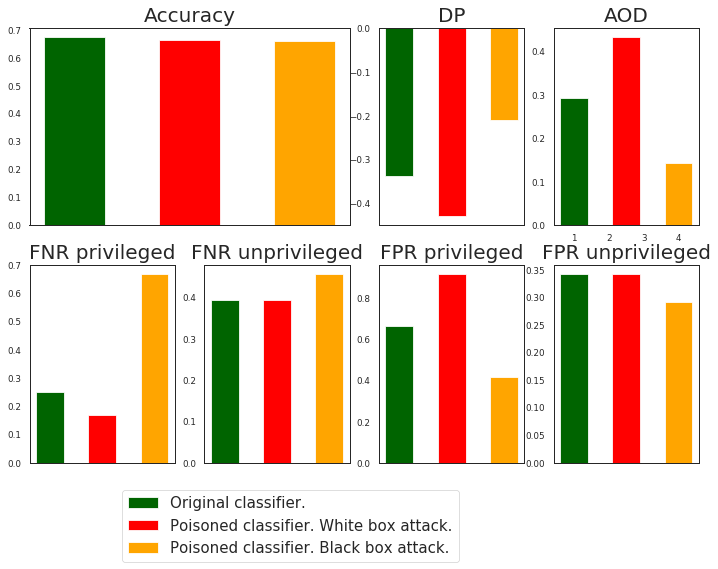

<Figure size 576x432 with 0 Axes>

In [19]:
plot_disparate_impact(dimp_scenarios, dimp_in_data)

In [12]:
RANGE = np.arange(0.05, 0.31, 0.02)

In [13]:
_results = []
for i in range(5):
    scenarios2 = []
    for perc_pois in RANGE:
        scenario = deepcopy(dimp_scenarios[0])

        print(scenario["training"])

        print("\n\n ==== {}-{} ====".format(scenario['name'], perc_pois))
        print("    - {}\n".format(scenario['description']))

        ################################
        ### ORIGINAL CLF PERFORMANCE ###
        ################################
        original_model, original_acc = train_LogReg(scenario["training"], scenario["test"])

        orig_y_pred = original_model.predict(scenario["test"].X)
        orig_FNR, orig_FPR = get_error_rates(scenario["test"].Y.get_data(), orig_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
        orig_disparate_imp = calculate_disparate_impact(orig_y_pred.get_data(), scenario["test_sensible_att"])
        orig_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), orig_y_pred.get_data(), scenario["test_sensible_att"])

        scenario['original_classifier'] = original_model
        scenario['original_acc'] = original_acc
        scenario['orig_d_imp'] = orig_disparate_imp
        scenario['orig_FNR'] = orig_FNR
        scenario['orig_FPR'] = orig_FPR
        scenario['orig_odds'] = orig_odds_diff


        ########################
        ### WHITE BOX ATTACK ###
        ########################
        white_pois_clf = deepcopy(original_model)

        privileged_condition_valid = np.ones(scenario['validation'].num_samples)
        privileged_condition_valid[scenario["validation_sensible_att"] == 0] == -1


        white_pois_points, white_pois_tr = execute_adversarial_attack(white_pois_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"], perc_pois)
        ## Retraining with poisoned points
        white_pois_clf = white_pois_clf.fit(white_pois_tr)
        white_pois_y_pred = white_pois_clf.predict(scenario["test"].X)

        metric = CMetricAccuracy()
        white_pois_acc = metric.performance_score(scenario["test"].Y, y_pred=white_pois_y_pred)
        white_pois_disparate_imp = calculate_disparate_impact(white_pois_y_pred.get_data(), scenario["test_sensible_att"])
        white_pois_FNR, white_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), white_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
        white_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), white_pois_y_pred.get_data(), scenario["test_sensible_att"])

        scenario['white_poisoned_classifier'] = white_pois_clf
        scenario['white_poisoned_points'] = white_pois_points
        scenario['white_pois_d_imp'] = white_pois_disparate_imp
        scenario['white_pois_y_pred'] = white_pois_y_pred
        scenario['white_pois_acc'] = white_pois_acc
        scenario['white_pois_FNR'] = white_pois_FNR
        scenario['white_pois_FPR'] = white_pois_FPR
        scenario['white_odds'] = white_odds_diff



        ########################
        ### BLACK BOX ATTACK ###
        ########################
        real_model, real_acc = train_SVM(scenario["training"], scenario["test"])

        surrogate_clf = deepcopy(original_model)

        black_pois_points, black_pois_tr = execute_adversarial_attack(surrogate_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"], perc_pois)
        ## Retraining with poisoned points

        black_pois_clf = deepcopy(real_model)
        black_pois_clf = black_pois_clf.fit(black_pois_tr)
        black_pois_y_pred = black_pois_clf.predict(scenario["test"].X)

        black_pois_acc = metric.performance_score(y_true=scenario["test"].Y, y_pred=black_pois_y_pred)
        black_pois_disparate_imp = calculate_disparate_impact(black_pois_y_pred.get_data(), scenario["test_sensible_att"])
        black_pois_FNR, black_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), black_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
        black_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), black_pois_y_pred.get_data(), scenario["test_sensible_att"])


        scenario['black_poisoned_classifier'] = black_pois_clf
        scenario['black_poisoned_points'] = black_pois_points
        scenario['black_pois_d_imp'] = black_pois_disparate_imp
        scenario['black_pois_y_pred'] = black_pois_y_pred
        scenario['black_pois_acc'] = black_pois_acc
        scenario['black_pois_FNR'] = black_pois_FNR
        scenario['black_pois_FPR'] = black_pois_FPR
        scenario['black_odds'] = black_odds_diff

        ################################
        ### CLASSIC POISONING ATTACK ###
        ################################
        normal_pois_clf = deepcopy(original_model)

        privileged_condition_valid = np.ones(scenario['validation'].num_samples)
        privileged_condition_valid[scenario["validation_sensible_att"] == 0] == -1


        normal_pois_points, normal_pois_tr = execute_normal_poisoning_attack(normal_pois_clf, scenario["training"], scenario["validation"], scenario["test"], scenario["test_sensible_att"], scenario["validation_sensible_att"], perc_pois)
        ## Retraining with poisoned points
        normal_pois_clf = normal_pois_clf.fit(normal_pois_tr)
        normal_pois_y_pred = normal_pois_clf.predict(scenario["test"].X)

        metric = CMetricAccuracy()
        normal_pois_acc = metric.performance_score(scenario["test"].Y, y_pred=normal_pois_y_pred)
        print("->> normal")
        normal_pois_disparate_imp = calculate_disparate_impact(normal_pois_y_pred.get_data(), scenario["test_sensible_att"])
        normal_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"])
        normal_pois_FNR, normal_pois_FPR = get_error_rates(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"], 1, 1)
        normal_odds_diff = get_average_odds_difference(scenario["test"].Y.get_data(), normal_pois_y_pred.get_data(), scenario["test_sensible_att"])

        scenario['normal_poisoned_classifier'] = normal_pois_clf
        scenario['normal_poisoned_points'] = normal_pois_points
        scenario['normal_pois_d_imp'] = normal_pois_disparate_imp
        scenario['normal_odds'] = normal_odds_diff
        scenario['normal_pois_y_pred'] = normal_pois_y_pred
        scenario['normal_pois_acc'] = normal_pois_acc
        scenario['normal_pois_FNR'] = normal_pois_FNR
        scenario['normal_pois_FPR'] = normal_pois_FPR
        scenario['normal_odds'] = normal_odds_diff


        scenarios2.append(scenario)
    _results.append(scenarios2)

CDataset{'X': CArray(422, 10)(dense: [[1. 0. 0. ... 0. 1. 0.] [0. 0. 0. ... 0. 0. 1.] [0. 0. 1. ... 1. 1. 0.] ... [0. 0. 1. ... 1. 1. 0.] [0. 0. 1. ... 0. 0. 1.] [0. 1. 1. ... 0. 1. 0.]]), 'Y': CArray(422,)(dense: [1. 1. 0. ... 1. 1. 1.]), 'header': None}


 ==== Use case 4 - 1-0.05 ====
    - Disparate impact attack. 
 Euclidean distance between group averages: 1


Estimating the best training parameters...
The best training parameters are:  {'C': 1}
Training of classifier complete!
Accuracy on test set: 67.30%
 ==> Adversarial attack. Percentage of samples: 0.05 
Creating 21 poisoning samples 
Attack started...
Attack complete!
Estimating the best training parameters...
The best training parameters are:  {'C': 10}
Training of classifier complete!
Accuracy on test set: 65.88%
 ==> Adversarial attack. Percentage of samples: 0.05 
Creating 21 poisoning samples 
Attack started...
Attack complete!
Creating 21 poisoning samples 
Attack started...
Attack complete!
->> normal
CDataset{'X': C

KeyboardInterrupt: 

In [ ]:
from matplotlib.gridspec import GridSpec
def plot_use_case_multiple_runs(scenarios, data_dimp=None , n_scenarios=5, title=None):
    
    _x_ = RANGE
    
    fig=plt.figure(figsize=[12,8])
    if title is not None:
        plt.suptitle(title, fontsize=14)

    gs=GridSpec(2,4) # 2 rows, 3 columns

    ax1=fig.add_subplot(gs[0,:2]) # Second row, span all columns
    ax1.set_title("Accuracy")
    
    ax1.plot(_x_,[float(UC["original_acc"]) for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax1.plot(_x_,[float(UC["white_pois_acc"]) for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax1.plot(_x_,[float(UC["black_pois_acc"]) for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax1.plot(_x_,[float(UC["normal_pois_acc"]) for UC in scenarios], '--', c="blue", label="Classic poisoning attack")
    

    ax2=fig.add_subplot(gs[0,2]) # First row, first column
    ax2.set_title("Demographic parity")
    ax2.plot(_x_,[UC["orig_d_imp"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    #if data_dimp is not None:
    #    ax2.plot(_x_,data_dimp, c="darkgrey", label="Original data")
    ax2.plot(_x_,[UC["white_pois_d_imp"] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax2.plot(_x_,[UC["black_pois_d_imp"] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax2.plot(_x_,[UC["normal_pois_d_imp"] for UC in scenarios], '--', c="blue", label="Classic poisoning attack")
    #ax2.legend(bbox_to_anchor=(1.1, -0.1),fontsize=15)
    
    ax2b=fig.add_subplot(gs[0,3]) # First row, first column
    ax2b.set_title("Average odds difference")
    ax2b.plot(_x_,[UC["orig_odds"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax2b.plot(_x_,[UC["white_odds"] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax2b.plot(_x_,[UC["black_odds"] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax2b.plot(_x_,[UC["normal_odds"] for UC in scenarios], '--', c="blue", label="Classic poisoning attack")
    
    ax3=fig.add_subplot(gs[1,0]) # First row, second column
    ax3.set_title("FNR privileged")
    ax3.plot(_x_,[UC["orig_FNR"]["FNR_privileged"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax3.plot(_x_,[UC["white_pois_FNR"]['FNR_privileged'] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax3.plot(_x_,[UC["black_pois_FNR"]['FNR_privileged'] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax3.plot(_x_,[UC["normal_pois_FNR"]['FNR_privileged'] for UC in scenarios], '--', c="blue", label="Classic poisoning attack")

    ax4=fig.add_subplot(gs[1,1]) # First row, third column
    ax4.set_title("FNR unprivileged")
    ax4.plot(_x_,[UC["orig_FNR"]["FNR_unprivileged"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax4.plot(_x_,[UC["white_pois_FNR"]['FNR_unprivileged'] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax4.plot(_x_,[UC["black_pois_FNR"]['FNR_unprivileged'] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax4.plot(_x_,[UC["normal_pois_FNR"]['FNR_unprivileged'] for UC in scenarios], '--', c="blue", label="Classic poisoning attack")
    #ax4.plot([], [], c="gray", label="Disparate impact in the data")
    
    ax4.legend(bbox_to_anchor=(1.8, -0.1),fontsize=15)
    
    ax5=fig.add_subplot(gs[1,2]) # First row, second column
    ax5.set_title("FPR privileged")
    ax5.plot(_x_,[UC["orig_FPR"]["FPR_privileged"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax5.plot(_x_,[UC["white_pois_FPR"]['FPR_privileged'] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax5.plot(_x_,[UC["black_pois_FPR"]['FPR_privileged'] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax5.plot(_x_,[UC["normal_pois_FPR"]['FPR_privileged'] for UC in scenarios], '--', c="blue", label="Classic poisoning attack")

    ax6=fig.add_subplot(gs[1,3]) # First row, third column
    ax6.set_title("FPR unprivileged")
    ax6.plot(_x_,[UC["orig_FPR"]["FPR_unprivileged"] for UC in scenarios], c="darkgreen", label="Original classifier.")
    ax6.plot(_x_,[UC["white_pois_FPR"]['FPR_unprivileged'] for UC in scenarios], c="red", label="Poisoned classifier. White box attack.")
    ax6.plot(_x_,[UC["black_pois_FPR"]['FPR_unprivileged'] for UC in scenarios], c="orange", label="Poisoned classifier. Black box attack.")
    ax6.plot(_x_,[UC["normal_pois_FPR"]['FPR_unprivileged'] for UC in scenarios], '--', c="blue", label="Classic poisoning attack")
    
    plt.plot()


In [ ]:
plot_use_case_multiple_runs(scenarios2, dimp_in_data)

In [ ]:
len(scenarios2)

In [ ]:
## Using different algorithms as black box

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

def train_models(X,y, X_test, y_test, sentitive_att_test):
    m1 = DecisionTreeClassifier().fit(X, y)
    m2 = RandomForestClassifier().fit(X, y)
    m3 = LogisticRegression(random_state=0).fit(X, y)
    m4 = SVC(kernel='linear').fit(X, y)
    m5 = GaussianNB().fit(X, y)
    #m6 = KNeighborsClassifier().fit(X, y)
    m7 = SVC(gamma='auto', kernel='rbf').fit(X,y)
    
    ms = [m1,m2,m3,m4,m5,m7]

    accs = []
    dimp = []
    avg_odds = []
    
    for m in ms:
        _preds = m.predict(X_test)
        accs.append(accuracy_score(y_test, _preds))
        dimp.append(calculate_disparate_impact(_preds, sentitive_att_test))
        avg_odds.append(get_average_odds_difference(y_test, _preds, sentitive_att_test))

    return accs,dimp,avg_odds

In [ ]:
_tmp = []
for i in range(len(_results[0])):
    
    t = []
    for j in range(len(_results)):
    

        sc = _results[j][i]
        tr = sc['training']
        ts = sc['test']
        ps = sc['white_poisoned_points']
        tr2 = tr.deepcopy().append(ps)
        sensitive_att = sc['test_sensible_att']
        for z in range(3):
            t.append(train_models(tr2.X.get_data(), tr2.Y.get_data(), ts.X.get_data(), ts.Y.get_data(), sensitive_att))

    accs = [c[0] for c in t]
    dimps = [c[1] for c in t]
    odds = [c[2] for c in t]

    accs_means = np.array(accs).mean(0)
    dimp_means = np.array(dimps).mean(0)
    odds_means = np.array(odds).mean(0)
    _tmp.append((accs_means, dimp_means, odds_means))

accs = [c[0] for c in _tmp]
dimps = [c[1] for c in _tmp]
odds = [c[2] for c in _tmp]

models = ["DecisionTree", "RandomForest", "LogReg", "Linear SVM", "GaussianNB", "RBF SVM"]
model_cs = ['b', 'g', 'k', 'r', 'm', 'k']
model_ms = ['^', (8,2,0), 'v', 'o', '+', '*']

In [ ]:
fig=plt.figure(figsize=[16,4])
ax=fig.add_subplot(131)

_x_ = RANGE
for i in range(len(accs[0])):
    t = [acc[i] for acc in accs]
    ax.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
ax.set_xlabel("% of poisoned samples")
ax.set_title("Accuracy")


ax2=fig.add_subplot(132)

_x_ = RANGE
for i in range(len(accs[0])):
    t = [dimp[i] for dimp in dimps]
    ax2.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
ax2.set_xlabel("% of poisoned samples")
ax2.set_title("Demographic parity")


ax3=fig.add_subplot(133)

_x_ = RANGE
for i in range(len(accs[0])):
    t = [odd[i] for odd in odds]
    ax3.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
ax3.set_xlabel("% of poisoned samples")
ax3.set_title("Average odds difference")

ax2.legend(bbox_to_anchor=(1.4, -.2), fontsize=15, ncol=3)
fig.suptitle("Performance of transfer attacks", x=0.5, y=1.1, fontsize=18)
plt.show()
fig.savefig("attack_compas_data_transf.eps", format='eps')

In [ ]:
def train_models2(ms, black_model, train_set, black_train_set, test_set, sensitive_att):
    
    accs = []
    dimp = []
    avg_odds = []
    
    y_test = test_set.Y.get_data()
    
    for m in ms:
        #m = m.fit(train_set)
        _preds = m.predict(test_set.X).get_data()
        accs.append(accuracy_score(y_test, _preds))
        dimp.append(calculate_disparate_impact(_preds, sensitive_att))
        avg_odds.append(get_average_odds_difference(y_test, _preds, sensitive_att))


    black_model = black_model.fit(black_train_set)   
    _preds2 = black_model.predict(test_set.X).get_data()
    
    accs.append(accuracy_score(y_test, _preds2))
    dimp.append(calculate_disparate_impact(_preds2, sensitive_att))
    avg_odds.append(get_average_odds_difference(y_test, _preds2, sensitive_att))    

    return accs,dimp,avg_odds
    

In [ ]:
accs = []
dimps = []
odds_means = []
_tmp = []
for i in range(len(_results[0])):
    
    t = []
    for j in range(len(_results)):
    

        sc = _results[j][i]
        tr = sc['training']
        ts = sc['test']
        ps = sc['white_poisoned_points']
        ps2 = sc['black_poisoned_points']
        
        m1 = sc['original_classifier']
        m2 = sc['white_poisoned_classifier']
        black_m = sc['black_poisoned_classifier']
        m4 = sc['normal_poisoned_classifier']
        ms = [m1,m2,m4]
        
        tr = tr.deepcopy().append(ps)
        tr2 = tr.deepcopy().append(ps2)
        
        sensitive_att = sc['test_sensible_att']
        
        #for z in range(3):
        t.append(train_models2(ms, black_m, tr, tr2, ts, sensitive_att))

    accs = [c[0] for c in t]
    dimps = [c[1] for c in t]
    odds = [c[2] for c in t]

    accs_means = np.array(accs).mean(0)
    dimp_means = np.array(dimps).mean(0)
    odds_means = np.array(odds).mean(0)
    _tmp.append((accs_means, dimp_means, odds_means))

accs = [c[0] for c in _tmp]
dimps = [c[1] for c in _tmp]
odds = [c[2] for c in _tmp]

models = ["Original model", "White-box attack", "Error-generic poisoning attack", "Black-box attack"]
model_cs = ['g', 'r', 'b', 'orange']
model_ms = ['^', (8,2,0), 'v', 'o', '+', '*']

In [ ]:
fig=plt.figure(figsize=[16,4])
ax=fig.add_subplot(131)

_x_ = RANGE
for i in range(len(accs[0])):
    t = [acc[i] for acc in accs]
    ax.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
ax.set_xlabel("% of poisoned samples")
ax.set_title("Accuracy")


ax2=fig.add_subplot(132)

_x_ = RANGE
for i in range(len(accs[0])):
    t = [dimp[i] for dimp in dimps]
    ax2.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
ax2.set_xlabel("% of poisoned samples")
ax2.set_title("Demographic parity")


ax3=fig.add_subplot(133)

_x_ = RANGE
for i in range(len(accs[0])):
    t = [odd[i] for odd in odds]
    ax3.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
ax3.set_xlabel("% of poisoned samples")
ax3.set_title("Average odds difference")

 
ax2.legend(bbox_to_anchor=(2, -.2), fontsize=15, ncol=4)
fig.suptitle("Performance of attacks on COMPAS data", x=0.5, y=1.1)
plt.show()

fig.savefig("attack_compas_data3.eps", format='eps')

In [ ]:
def train_models2(ms, black_model, train_set, black_train_set, test_set, sensitive_att):
    
    accs = []
    dimp = []
    avg_odds = []
    
    fpr_priv = []
    fpr_unpriv = []
    fnr_priv = []
    fnr_unpriv = []
    
    y_test = test_set.Y.get_data()
    
    for m in ms:
        #m = m.fit(train_set)
        _preds = m.predict(test_set.X).get_data()
        accs.append(accuracy_score(y_test, _preds))
        dimp.append(calculate_disparate_impact(_preds, sensitive_att))
        avg_odds.append(get_average_odds_difference(y_test, _preds, sensitive_att))
        
        errors = get_error_rates(y_test, _preds, sensitive_att)
        
        fnr_priv.append(errors[0]['FNR_privileged'])
        fnr_unpriv.append(errors[0]['FNR_unprivileged'])
        
        fpr_priv.append(errors[1]['FPR_privileged'])
        fpr_unpriv.append(errors[1]['FPR_unprivileged'])

    #black_model = black_model.fit(black_train_set)   
    _preds2 = black_model.predict(test_set.X).get_data()
    
    accs.append(accuracy_score(y_test, _preds2))
    dimp.append(calculate_disparate_impact(_preds2, sensitive_att))
    avg_odds.append(get_average_odds_difference(y_test, _preds2, sensitive_att))  
    errors = get_error_rates(y_test, _preds2, sensitive_att)
        
    fnr_priv.append(errors[0]['FNR_privileged'])
    fnr_unpriv.append(errors[0]['FNR_unprivileged'])

    fpr_priv.append(errors[1]['FPR_privileged'])
    fpr_unpriv.append(errors[1]['FPR_unprivileged'])

    return accs,dimp,avg_odds, fnr_priv, fnr_unpriv, fpr_priv, fpr_unpriv
    
accs = []
dimps = []
odds_means = []
_tmp = []
for i in range(len(_results[0])):
    
    t = []
    for j in range(len(_results)):
    

        sc = _results[j][i]
        tr = sc['training']
        ts = sc['test']
        ps = sc['white_poisoned_points']
        ps2 = sc['black_poisoned_points']
        
        m1 = sc['original_classifier']
        m2 = sc['white_poisoned_classifier']
        black_m = sc['black_poisoned_classifier']
        m4 = sc['normal_poisoned_classifier']
        ms = [m1,m2,m4]
        
        tr = tr.deepcopy().append(ps)
        tr2 = tr.deepcopy().append(ps2)
        
        sensitive_att = sc['test_sensible_att']
        
        for z in range(3):
            t.append(train_models2(ms, black_m, tr, tr2, ts, sensitive_att))

    accs = [c[0] for c in t]
    dimps = [c[1] for c in t]
    odds = [c[2] for c in t]
    fnr_priv = [c[3] for c in t] 
    fnr_unpriv = [c[4] for c in t]
    fpr_priv = [c[5] for c in t]
    fpr_unpriv = [c[6] for c in t]

    accs_means = np.array(accs).mean(0)
    dimp_means = np.array(dimps).mean(0)
    odds_means = np.array(odds).mean(0)
    fnr_p_means = np.array(fnr_priv).mean(0)
    fnr_u_means = np.array(fnr_unpriv).mean(0)
    fpr_p_means = np.array(fpr_priv).mean(0)
    fpr_u_means = np.array(fpr_unpriv).mean(0)
    
    
    
    _tmp.append((accs_means, dimp_means, odds_means,fnr_p_means,fnr_u_means,fpr_p_means,fpr_u_means))

accs = [c[0] for c in _tmp]
dimps = [c[1] for c in _tmp]
odds = [c[2] for c in _tmp]
fnr_priv = [c[3] for c in _tmp] 
fnr_unpriv = [c[4] for c in _tmp]
fpr_priv = [c[5] for c in _tmp]
fpr_unpriv = [c[6] for c in _tmp]

models = ["Original model", "White-box attack", "Error-generic poisoning attack", "Black-box attack"]
model_cs = ['g', 'r', 'b', 'orange']
model_ms = ['^', (8,2,0), 'v', 'o', '+', '*']




In [ ]:
fig=plt.figure(figsize=[16,8])

gs=GridSpec(2,4) # 2 rows, 4 columns

ax=fig.add_subplot(gs[0,:2]) # Second row, span all columns


_x_ = list(range(len(_results[0])))
for i in range(len(accs[0])):
    t = [acc[i] for acc in accs]
    c = model_cs[i]
    mark = model_ms[i]
    l = models[i]
    ax.plot(_x_,t,c=c,marker=mark,ls=':',label=l)
    
#ax.set_xlabel(_x_)    
#ax.set_xlabel("Euclidean distance in data")
ax.set_title("Accuracy")


ax2=fig.add_subplot(gs[0,2]) # Second row, span all columns

_x_ = list(range(len(_results[0])))
for i in range(len(accs[0])):
    t = [dimp[i] for dimp in dimps]
    ax2.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax2.set_xlabel("Euclidean distance")
ax2.set_title("Demographic parity")


ax3=fig.add_subplot(gs[0,3])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [odd[i] for odd in odds]
    ax3.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax3.set_xlabel("Euclidean distance")
ax3.set_title("Average odds difference")


ax4=fig.add_subplot(gs[1,0])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [fnr_p[i] for fnr_p in fnr_priv]
    ax4.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax4.set_xlabel("Euclidean distance")
ax4.set_title("FNR privileged")

ax5=fig.add_subplot(gs[1,1])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [fnr_up[i] for fnr_up in fnr_unpriv]
    ax5.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax5.set_xlabel("Euclidean distance")
ax5.set_title("FNR unprivileged")

ax6=fig.add_subplot(gs[1,2])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [fpr_p[i] for fpr_p in fpr_priv]
    ax6.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax6.set_xlabel("Euclidean distance")
ax6.set_title("FPR privileged")

ax7=fig.add_subplot(gs[1,3])

_x_ = list(range(len(_results[0])))

for i in range(len(accs[0])):
    t = [fpr_up[i] for fpr_up in fpr_unpriv]
    ax7.plot(_x_,t,c=model_cs[i],marker=model_ms[i],ls=':',label=models[i])
    
#ax.set_xlabel(_x_)    
#ax7.set_xlabel("Euclidean distance")
ax7.set_title("FPR unprivileged")

 
ax6.legend(bbox_to_anchor=(0.5, -.2), fontsize=15)
fig.suptitle("Performance of attacks on synthetic data", x=0.5, y=1)



fig.align_labels() 
plt.show()
fig.savefig("attack_compas_data2.eps", format='eps')

In [ ]:
accs

In [ ]:
_metrics = [accs,dimps,odds,fnr_priv,fnr_unpriv,fpr_priv,fpr_unpriv]
_metric_names = ["Accuracy", "Demographic parity", "Average odds difference", "FNR priv", "FNR unpriv", "FPR priv", "FPR unpriv"]
for m_idx, m in enumerate(_metrics):
    m = np.array(m)
    if m_idx != 3:
        print(" -- {} -- ".format(_metric_names[m_idx]))
        print(" Generic/Orig: {}".format(np.mean(m[:,2]/m[:,0])))
        print(" White/Orig: {}".format(np.mean(m[:,3]/m[:,0])))
        print(" Black/Orig: {}".format(np.mean(m[:,1]/m[:,0])))
    else:        
        print(" -- {} -- ".format(_metric_names[m_idx]))
        print(" Generic/Orig: {}".format(np.mean(m[:,2][:-1] / m[:,0][:-1])))
        print(" White/Orig: {}".format(np.mean(m[:,3][:-1] / m[:,0][:-1])))
        print(" Black/Orig: {}".format(np.mean(m[:,1][:-1] / m[:,0][:-1])))